<p style="text-align: center;">
    МИНОБРНАУКИ РОССИИ <br>
    РГУ НЕФТИ И ГАЗА (НИУ) ИМЕНИ И.М. ГУБКИНА<br>
    ФАКУЛЬТЕТ АВТОМАТИКИ И ВЫЧИСЛИТЕЛЬНОЙ ТЕХНИКИ<br>
    КАФЕДРА АВТОМАТИЗИРОВАННЫХ СИСТЕМ УПРАВЛЕНИЯ<br>
    ДИСЦИПЛИНА <br>
        «Модели и методы обработки статистической информации в автоматизированном управлении НГО»
    <br><br> <br> <br> <br> <br> <br><br>
    ОТЧЁТ <br>
    по лабораторной работе №3 <br>
    «Корреляционный анализ»<br> <br> <br> <br> <br><br> <br> <br> <br> <br> <br><br>  <br> <br> <br> <br> <br> <br><br>
</p>

<p style="text-align: right;">
    Выполнил: студент группы АС-21-05, Негробов В.А.<br>
    Проверила: старший преподаватель, Степанкина О.А.<br><br> <br> <br> <br> <br><br> <br> <br> <br> <br> <br> <br> <br><br><br> <br> <br> <br> <br><br>
</p>

<p style="text-align: center;">
    МОСКВА 2024
</p>

----------------------------------------------------------------------------------------
<br><br>Вариант 14 (2)
Дано 5 одномерных случайных величин (одномерных выборок), необходимо провести корреляционный анализ данных.

Необходимо:
1. Построить корреляционную матрицу (парные коэффициенты корреляции); 
2. найти частные коэффициенты корреляции;
3. множественные коэффициенты корреляции;
4. ранговые коэффициенты корреляции;
5. коэффициенты  корреляционного отношения.

Для всех коэффициентов обязательна проверка на значимость.

Подключение используемых библиотек и стиля отображаемых графиков:

In [131]:
import pandas as pd
import numpy as np
import pingouin as pg
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import scipy
from statsmodels.formula.api import ols

plt.style.use('ggplot')
pd.set_option('mode.use_inf_as_na', True)

C:\Users\vikto\AppData\Local\Temp\ipykernel_17520\2910443706.py:11: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.set_option('mode.use_inf_as_na', True)


Функция подсчёта корреляции, необходимая для использования корреляции Пирсона и Спирмена:

In [132]:
def get_correlation(df, corr_function, simmetric=True):
    names = df.columns
    length = len(names)
    correlation = np.zeros((length, length))
    p_values = np.zeros((length, length))
    
    if simmetric:
        for i in range(length):
            for j in range(i, length):
                res = corr_function(df[names[i]], df[names[j]])
                correlation[i, j] = correlation[j, i] = res[0]
                p_values[i, j] = p_values[j, i] = res[1]
    else:
        for i in range(length):
            for j in range(length):
                res = corr_function(df[names[i]], df[names[j]])
                correlation[i, j] = res[0]
                p_values[i, j] = res[1]
    
    df_correlation = pd.DataFrame(correlation)
    df_p_values = pd.DataFrame(p_values)
    df_correlation.columns = df_p_values.columns = names
    df_correlation.index = df_p_values.index = names
    
    return df_correlation, df_p_values

Функция подсчёта частных коэффициентов корреляции:

In [133]:
def partial_correlation(df):
    names = df.columns
    length = len(names)
    correlation = np.zeros((length, length))
    correlation[range(length), range(length)] = 1
    p_values = np.zeros((length, length))
    p_values[range(length), range(length)] = 0

    for i in range(length):
        for j in range(i + 1, length):
            cov_names = list(df.columns)
            cov_names.remove(names[i])
            if names[j] in cov_names:
                cov_names.remove(names[j])
            res = pg.partial_corr(data=df, x=names[i], y=names[j], covar=cov_names)
            correlation[i, j] = correlation[j, i] = res['r'].values
            p_values[i, j] = p_values[j, i] = res['p-val'].values
    df_correlation = pd.DataFrame(correlation)
    df_p_values = pd.DataFrame(p_values)
    df_correlation.columns = df_p_values.columns = names
    df_correlation.index = df_p_values.index = names
    
    return df_correlation, df_p_values

In [134]:
def multiple_correlation(df):
    names = df.columns
    length = len(names)
    correlation = np.zeros((length))
    p_values = np.zeros((length))
    
    for i, name in enumerate(names):
        formula = name + ' ~ ' + ' + '.join([n for j, n in enumerate(names) if j != i])
        mod = ols(formula=formula, data=df)
        res = mod.fit()
        correlation[i] = res.rsquared ** 0.5
        p_values[i] = res.f_pvalue
    
    return correlation, p_values

Функция подсчёта множественных коэффициентов корреляции:

In [135]:
def correlation_relation(var1, var2, n_bins=5):

    length = len(var1)
    group_int_number = lambda n: round (3.31*np.log10(n)+1) if round (3.31*np.log10(n)+1) >=2 else 2

    n_bins = group_int_number(length)
    n_bins
    bins = np.linspace(var1.min(), var1.max(), n_bins)
    args = np.digitize(var1, bins)

    groups = [list() for _ in range(n_bins)]

    for idx, bin_num in enumerate(args):
        groups[bin_num - 1].append(var2[idx])

    groups = [np.array(group) for group in groups if group]
    groups

    gen_mean = var2.mean()
    gen_var = var2.var()
    factor_var = sum((group.mean() - gen_mean)**2 * len(group) for group in groups) / length
    etto = (factor_var / gen_var) ** 0.5
    statistic = (length - n_bins)/(n_bins - 1) * etto ** 2 / (1 - etto ** 2)
    p_value = 1 - scipy.stats.f.cdf(statistic, (n_bins - 1), (length - n_bins), loc=0, scale=1)
    return etto, p_value

Определение гиперпараметров:

In [136]:
length = 5
names = [f'var{i + 1}' for i in range(length)]

Считывание данных:

In [137]:
df_base = pd.read_excel('ms-data2-2022.xlsx', sheet_name='2-2',
                   header=None, names=names)
df_base.head()

,var1,var2,var3,var4,var5
0,4.519,7.698,23.751,18.929,10.421
1,1.880,5.603,0.274,3.846,4.352
2,3.543,5.828,15.930,5.631,6.402
3,3.407,6.534,14.081,4.395,10.098
4,3.102,6.398,15.516,9.742,3.777


Парные графики переменных:

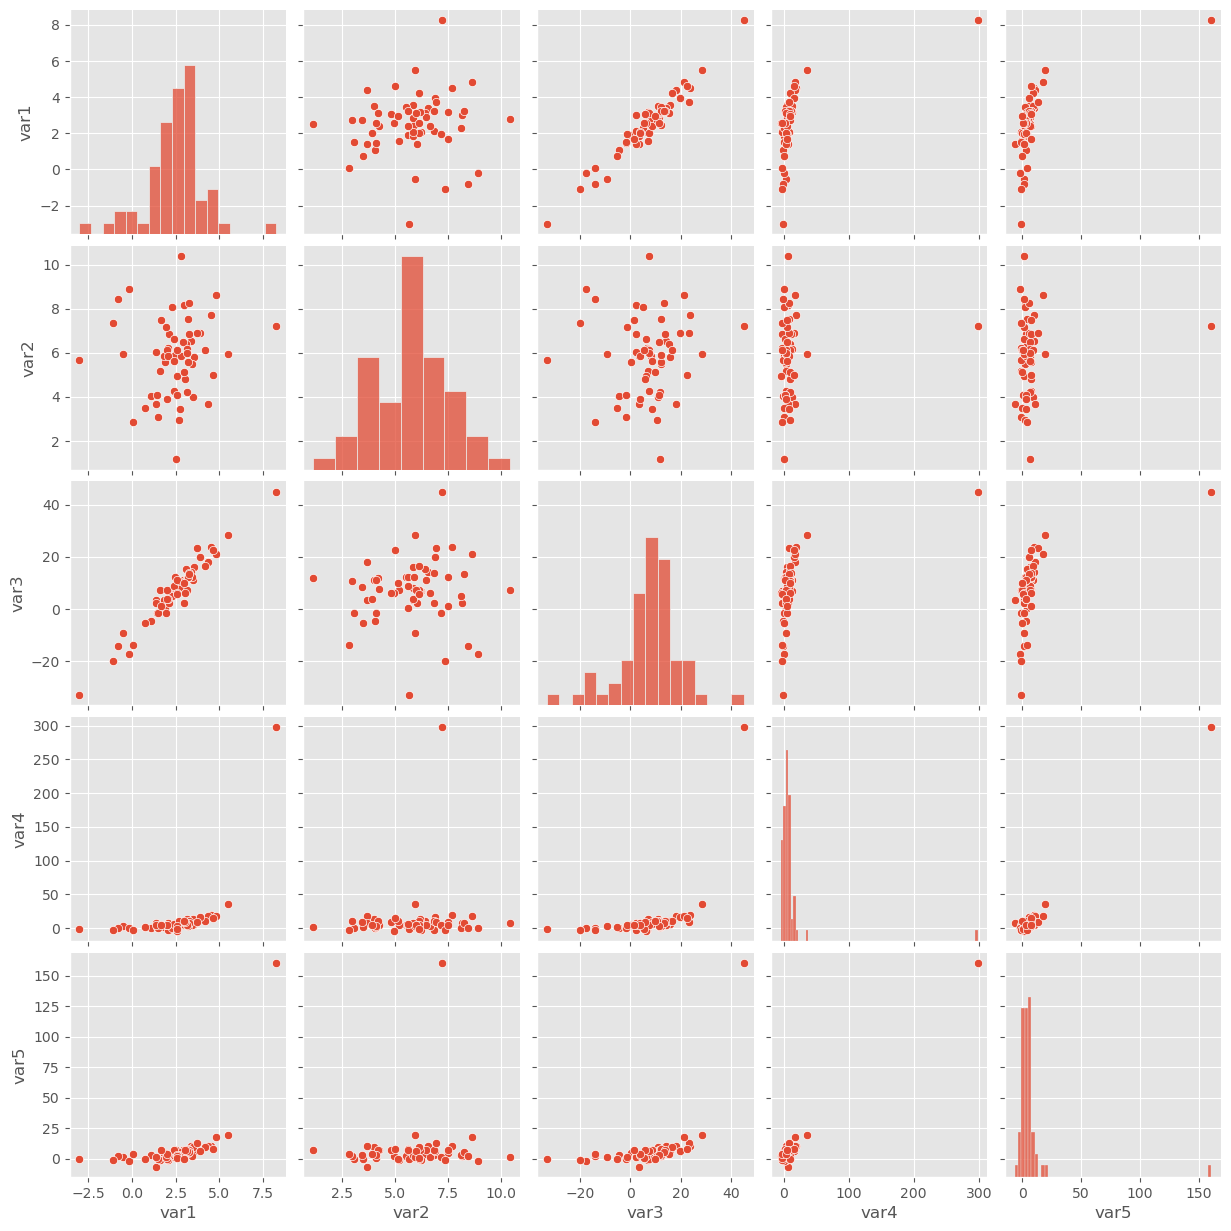

In [138]:
sns.pairplot(df_base);

# 1. Построить корреляционную матрицу (парные коэффициенты корреляции);

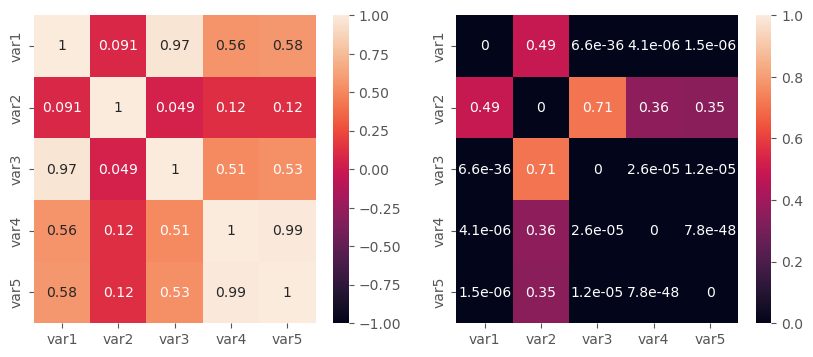

In [139]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

corr, p_vals = get_correlation(df_base, pearsonr)
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, ax=ax1);
sns.heatmap(p_vals, annot=True, vmin=0, vmax=1, ax=ax2);

# 2. найти частные коэффициенты корреляции;

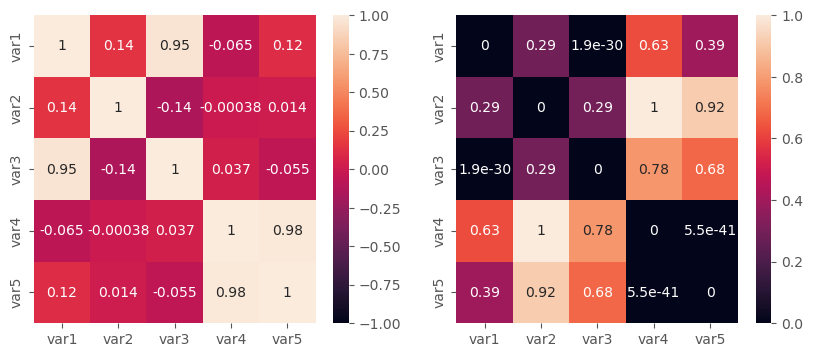

In [140]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

corr, p_vals = partial_correlation(df_base)
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, ax=ax1);
sns.heatmap(p_vals, annot=True, vmin=0, vmax=1, ax=ax2);

# 3. множественные коэффициенты корреляции;

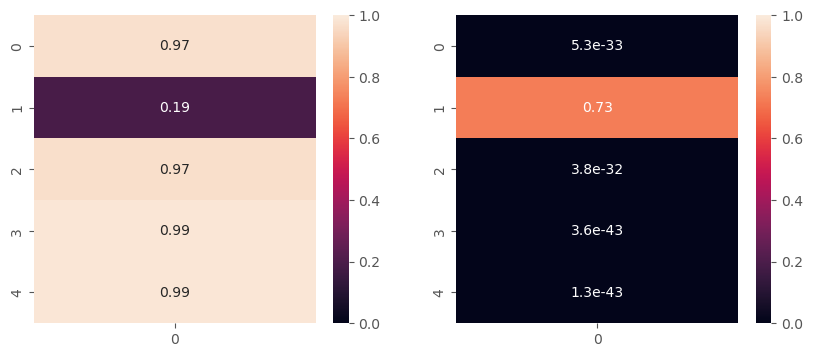

In [141]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
corr, p_vals = multiple_correlation(df_base)
sns.heatmap(corr[..., None], annot=True, vmin=0, vmax=1, ax=ax1);
sns.heatmap(p_vals[..., None], annot=True, vmin=0, vmax=1, ax=ax2);

# 4. ранговые коэффициенты корреляции;

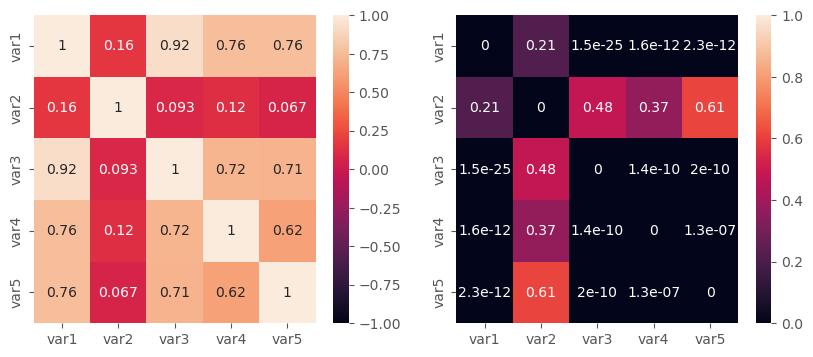

In [142]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

corr, p_vals = get_correlation(df_base, spearmanr)
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, ax=ax1);
sns.heatmap(p_vals, annot=True, vmin=0, vmax=1, ax=ax2);

# 5. коэффициенты корреляционного отношения.

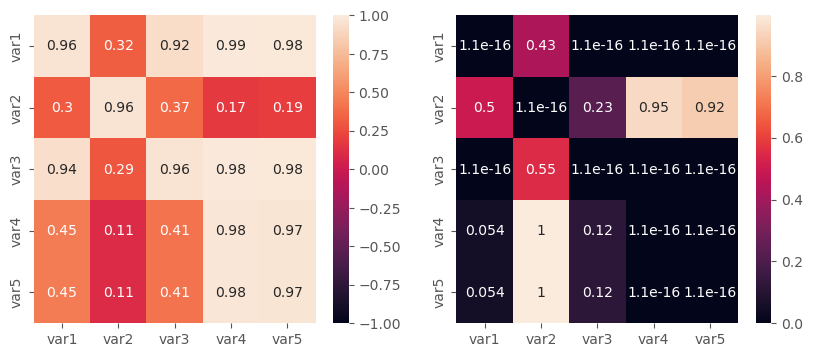

In [144]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

corr, p_vals = get_correlation(df_base, correlation_relation, simmetric=False)
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, ax=ax1);
sns.heatmap(p_vals, annot=True, ax=ax2);

Корреляционные отношения в левом нижнем углу меньше коэффициентов корреляции из-за того, что связь между переменными слабая, возможно нелинейная, и в данных находится выброс

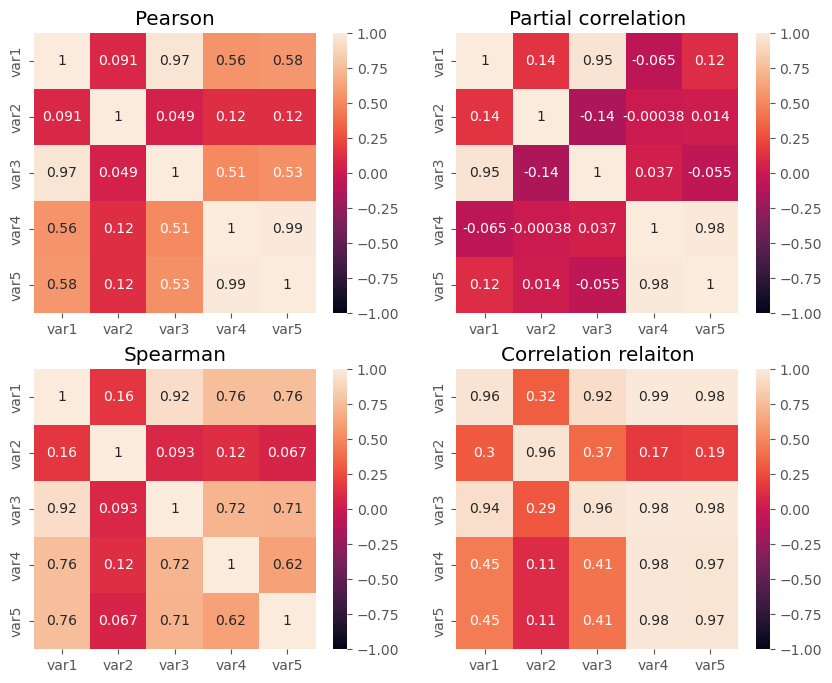

In [150]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))
ax1.set_title('Pearson')
ax2.set_title('Partial correlation')
ax3.set_title('Spearman')
ax4.set_title('Correlation relaiton')

corr, p_vals = get_correlation(df_base, pearsonr)
sns.heatmap(get_correlation(df_base, pearsonr)[0], annot=True, vmin=-1, vmax=1, ax=ax1);
sns.heatmap(partial_correlation(df_base)[0], annot=True, vmin=-1, vmax=1, ax=ax2);
sns.heatmap(get_correlation(df_base, spearmanr)[0], annot=True, vmin=-1, vmax=1, ax=ax3);
sns.heatmap(get_correlation(df_base, correlation_relation, simmetric=False)[0], annot=True, vmin=-1, vmax=1, ax=ax4);